## Загрузим нужные библиотеки

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import re, nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk import ngrams
import pymorphy2

from wordcloud import WordCloud

import torch
import transformers

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import tree
import numpy as np
from sklearn.metrics import f1_score

import numpy as np 
from sklearn.utils.class_weight import compute_class_weight

from catboost import CatBoostRegressor
from catboost import cv, Pool

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from scipy.sparse import hstack


%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Anastasia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Anastasia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Anastasia\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Считаем тренировочный набор

In [ ]:
df_issues_train = pd.read_csv("/content/train_issues.csv")
df_comment_train = pd.read_csv("/content/train_comments.csv")

df_emp = pd.read_csv("/content/employees.csv")

In [ ]:
df_issues_test = pd.read_csv("/content/test_issues.csv")
df_comment_test = pd.read_csv("/content/test_comments.csv")

## Первичный анализ

In [ ]:
df_issues_train.head(3)

,id,created,key,summary,project_id,assignee_id,creator_id,overall_worklogs
0,819952,2019-10-01 05:57:18.000,SM-10678,"UI тесты по заказу ""Добро КейДжи""",5,93,93,1800
1,819949,2019-10-01 05:59:45.000,SM-10679,"UI тесты раздела ""Профиль""",5,93,93,7200
2,819947,2019-10-01 06:00:38.000,SM-10680,"UI тесты раздела ""Личный счет""",5,93,93,14400


In [ ]:
df_issues_test.head(3)

,id,created,key,summary,project_id,assignee_id,creator_id
0,675975,2020-01-15 09:52:57.000,SM-11140,Выгрузить все mp3 файлы звонков на диск,5,112,112
1,675972,2020-01-15 09:54:35.000,SM-11141,Удалить файлы mp3 звонков с сервера до 01.01.2019,5,112,112
2,675965,2020-01-16 04:46:17.000,SM-11144,Удалить окно выбора тарифов и перенести функци...,5,94,54


In [ ]:
df_issues_train.shape

(9589, 8)

In [ ]:
df_issues_test.shape

(1070, 7)

In [ ]:
df_issues_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9589 entries, 0 to 9588
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                9589 non-null   int64 
 1   created           9589 non-null   object
 2   key               9589 non-null   object
 3   summary           9589 non-null   object
 4   project_id        9589 non-null   int64 
 5   assignee_id       9589 non-null   int64 
 6   creator_id        9589 non-null   int64 
 7   overall_worklogs  9589 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 599.4+ KB


In [ ]:
df_issues_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           1070 non-null   int64 
 1   created      1070 non-null   object
 2   key          1070 non-null   object
 3   summary      1070 non-null   object
 4   project_id   1070 non-null   int64 
 5   assignee_id  1070 non-null   int64 
 6   creator_id   1070 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 58.6+ KB


In [ ]:
df_comment_train.head(3)

,comment_id,text,issue_id,author_id
0,11779,[https://www.youtube.com/watch?v=tuhOdtsvoNY|h...,669666,1
1,10601,OK [~accountid:557058:3f7ab89a-8969-4547-90df-...,669670,1
2,76101,I encountered a problem with access to `/users...,670930,2


In [ ]:
df_comment_test.head(3)

,comment_id,text,issue_id,author_id
0,76324,I wasted much time building one graph by using...,670929,2
1,75499,почитал статьи по переносу доменов на клаудфей...,675831,112
2,75519,Посмотрел еще раз как переносят сайты на клауд...,675831,112


In [ ]:
df_comment_train['issue_id'].value_counts()

688628    135
727752    108
686683    107
686645    105
688826    101
         ... 
724624      1
724632      1
724638      1
724642      1
689226      1
Name: issue_id, Length: 3945, dtype: int64

In [ ]:
df_comment_test['issue_id'].value_counts()

686526    145
686475     34
686460     26
721534     22
721286     12
         ... 
700035      1
721454      1
721456      1
700033      1
670929      1
Name: issue_id, Length: 479, dtype: int64

Поработаем с этой таблицей. Оставим только уникальные значения issue_id. Для каждого из них соберём вместе тексты комментариев и добавим столбец с количеством комментариев

In [ ]:
ides = []
for i, row in df_comment_train.iterrows():
  if row['issue_id'] in ides:
    df_comment_train[df_comment_train['issue_id'] == row['issue_id']]['text'] = df_comment_train[df_comment_train['issue_id'] == row['issue_id']]['text']  + row['text']
    df_comment_train = df_comment_train.drop(i, axis=0)

  ides.append(row['issue_id'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
ides = []
for i, row in df_comment_test.iterrows():
  if row['issue_id'] in ides:
    df_comment_test[df_comment_test['issue_id'] == row['issue_id']]['text'] = df_comment_test[df_comment_test['issue_id'] == row['issue_id']]['text']  + row['text']
    df_comment_test = df_comment_test.drop(i, axis=0)

  ides.append(row['issue_id'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_comment_train.shape

(3945, 4)

In [ ]:
df_comment_test.shape

(479, 4)

In [ ]:
df_comment_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3945 entries, 0 to 13917
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   comment_id  3945 non-null   int64 
 1   text        3945 non-null   object
 2   issue_id    3945 non-null   int64 
 3   author_id   3945 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 154.1+ KB


In [ ]:
df_comment_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 479 entries, 0 to 1344
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   comment_id  479 non-null    int64 
 1   text        479 non-null    object
 2   issue_id    479 non-null    int64 
 3   author_id   479 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 18.7+ KB


### Преобразование столбцов

Удалим не нужную информацию о работниках

In [ ]:
df_emp = df_emp.drop(["active","full_name", "salary_calculation_type", "passport"],axis = 1)

Обьединим два набора данных по id исполнителя

In [ ]:
df_train = pd.merge(df_issues_train, df_emp, left_on="assignee_id", right_on="id", how='inner')

In [ ]:
df_train = pd.merge(df_train, df_comment_train, left_on="id_x", right_on="issue_id", how='left')

In [ ]:
df_train.shape

(9589, 21)

In [ ]:
df_train

,id_x,created,key,summary,project_id,assignee_id,creator_id,overall_worklogs,id_y,position,...,payment_type,english_level,is_nda_signed,is_labor_contract_signed,is_added_to_internal_chats,is_added_one_to_one,comment_id,text,issue_id,author_id
0,819952,2019-10-01 05:57:18.000,SM-10678,"UI тесты по заказу ""Добро КейДжи""",5,93,93,1800,93,Разработчик мобильных приложений,...,fixed,NaN,1,1,1,1,NaN,NaN,NaN,NaN
1,819949,2019-10-01 05:59:45.000,SM-10679,"UI тесты раздела ""Профиль""",5,93,93,7200,93,Разработчик мобильных приложений,...,fixed,NaN,1,1,1,1,65956.0,Приверила и приняла MR\n\n,819949.0,8.0
2,819947,2019-10-01 06:00:38.000,SM-10680,"UI тесты раздела ""Личный счет""",5,93,93,14400,93,Разработчик мобильных приложений,...,fixed,NaN,1,1,1,1,NaN,NaN,NaN,NaN
3,819943,2019-10-01 06:02:49.000,SM-10682,"UI тесты раздела ""Новости""",5,93,93,900,93,Разработчик мобильных приложений,...,fixed,NaN,1,1,1,1,NaN,NaN,NaN,NaN
4,819941,2019-10-01 06:03:26.000,SM-10683,"UI тесты раздела ""Зоны скидок и доплат""",5,93,93,900,93,Разработчик мобильных приложений,...,fixed,NaN,1,1,1,1,65960.0,Приняла mR,819941.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9584,688397,2020-01-24 05:40:31.000,XXO-213,Layout - Service and postcode search results p...,33,98,58,18000,98,Web-разработчик,...,fixed,NaN,1,1,1,1,69996.0,[Alisa|https://gitlab.com/ally-8253] mentioned...,688397.0,58.0
9585,670934,2020-06-02 10:08:14.000,LJ-1,Set up the neo4j by using a dataset from Slack,56,2,2,16200,2,Web-разработчик,...,fixed,NaN,0,0,0,0,75770.0,I have read the neo4j documentation and also I...,670934.0,2.0
9586,670932,2020-06-05 09:52:12.000,LJ-3,Set up a graph in neo4j by GitLab dataset,56,2,2,3600,2,Web-разработчик,...,fixed,NaN,0,0,0,0,NaN,NaN,NaN,NaN
9587,670931,2020-06-05 13:46:38.000,LJ-4,Parse a dataset from teacherly slack,56,2,2,6300,2,Web-разработчик,...,fixed,NaN,0,0,0,0,NaN,NaN,NaN,NaN


In [ ]:
df_test = pd.merge(df_issues_test, df_emp, left_on="assignee_id", right_on="id", how='inner')

In [ ]:
df_test = pd.merge(df_test, df_comment_test, left_on="id_x", right_on="issue_id", how='left')

In [ ]:
df_test.shape

(1070, 20)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9589 entries, 0 to 9588
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_x                        9589 non-null   int64  
 1   created                     9589 non-null   object 
 2   key                         9589 non-null   object 
 3   summary                     9589 non-null   object 
 4   project_id                  9589 non-null   int64  
 5   assignee_id                 9589 non-null   int64  
 6   creator_id                  9589 non-null   int64  
 7   overall_worklogs            9589 non-null   int64  
 8   id_y                        9589 non-null   int64  
 9   position                    7354 non-null   object 
 10  hiring_type                 7630 non-null   object 
 11  payment_type                7529 non-null   object 
 12  english_level               534 non-null    object 
 13  is_nda_signed               9589 

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1070 entries, 0 to 1069
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_x                        1070 non-null   int64  
 1   created                     1070 non-null   object 
 2   key                         1070 non-null   object 
 3   summary                     1070 non-null   object 
 4   project_id                  1070 non-null   int64  
 5   assignee_id                 1070 non-null   int64  
 6   creator_id                  1070 non-null   int64  
 7   id_y                        1070 non-null   int64  
 8   position                    806 non-null    object 
 9   hiring_type                 912 non-null    object 
 10  payment_type                899 non-null    object 
 11  english_level               37 non-null     object 
 12  is_nda_signed               1070 non-null   int64  
 13  is_labor_contract_signed    1070 

In [ ]:
df_train.isna().sum()

id_x                             0
created                          0
key                              0
summary                          0
project_id                       0
assignee_id                      0
creator_id                       0
overall_worklogs                 0
id_y                             0
position                      2235
hiring_type                   1959
payment_type                  2060
english_level                 9055
is_nda_signed                    0
is_labor_contract_signed         0
is_added_to_internal_chats       0
is_added_one_to_one              0
comment_id                    5644
text                          5644
issue_id                      5644
author_id                     5644
dtype: int64

In [ ]:
df_test.isna().sum()

id_x                             0
created                          0
key                              0
summary                          0
project_id                       0
assignee_id                      0
creator_id                       0
id_y                             0
position                       264
hiring_type                    158
payment_type                   171
english_level                 1033
is_nda_signed                    0
is_labor_contract_signed         0
is_added_to_internal_chats       0
is_added_one_to_one              0
comment_id                     591
text                           591
issue_id                       591
author_id                      591
dtype: int64

In [ ]:
df = df_train.drop_duplicates().reset_index(drop=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9589 entries, 0 to 9588
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_x                        9589 non-null   int64  
 1   created                     9589 non-null   object 
 2   key                         9589 non-null   object 
 3   summary                     9589 non-null   object 
 4   project_id                  9589 non-null   int64  
 5   assignee_id                 9589 non-null   int64  
 6   creator_id                  9589 non-null   int64  
 7   overall_worklogs            9589 non-null   int64  
 8   id_y                        9589 non-null   int64  
 9   position                    7354 non-null   object 
 10  hiring_type                 7630 non-null   object 
 11  payment_type                7529 non-null   object 
 12  english_level               534 non-null    object 
 13  is_nda_signed               9589 

#### id_x

In [ ]:
df['id_x'].value_counts()

819952    1
700121    1
700119    1
700118    1
700117    1
         ..
730503    1
730501    1
730500    1
730498    1
670930    1
Name: id_x, Length: 9589, dtype: int64

In [ ]:
df_test['id_x'].value_counts()

675975    1
721652    1
721757    1
721755    1
721748    1
         ..
720977    1
720971    1
720969    1
720959    1
670929    1
Name: id_x, Length: 1070, dtype: int64

#### created

In [ ]:
df['created'].head(3)

0    2019-10-01 05:57:18.000
1    2019-10-01 05:59:45.000
2    2019-10-01 06:00:38.000
Name: created, dtype: object

Приведём столбец к типу datetime и вычленим год, месяц и число как отдельные фичи

In [ ]:
df['created'] =  pd.to_datetime(df['created'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
df['created_year'] = df['created'].dt.year

In [ ]:
df['created_month'] = df['created'].dt.month

In [ ]:
df['created_day'] = df['created'].dt.day

In [ ]:
df['created_hour'] = df['created'].dt.hour

In [ ]:
df['created_minute'] = df['created'].dt.minute

In [ ]:
df['created_second'] = df['created'].dt.second

In [ ]:
df_test['created'].head(3)

0    2020-01-15 09:52:57.000
1    2020-01-15 09:54:35.000
2    2020-02-01 02:24:11.000
Name: created, dtype: object

Приведём столбец к типу datetime и вычленим год, месяц и число как отдельные фичи

In [ ]:
df_test['created'] =  pd.to_datetime(df_test['created'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
df_test['created_year'] = df_test['created'].dt.year

In [ ]:
df_test['created_month'] = df_test['created'].dt.month

In [ ]:
df_test['created_day'] = df_test['created'].dt.day

In [ ]:
df_test['created_hour'] = df_test['created'].dt.hour

In [ ]:
df_test['created_minute'] = df_test['created'].dt.minute

In [ ]:
df_test['created_second'] = df_test['created'].dt.second

#### created_year

In [ ]:
df['created_year'].describe()

count    9589.000000
mean     2019.455418
std         0.744202
min      2017.000000
25%      2019.000000
50%      2020.000000
75%      2020.000000
max      2021.000000
Name: created_year, dtype: float64

In [ ]:
df['created_year'].value_counts()

2020    5608
2019    2887
2018     895
2017     186
2021      13
Name: created_year, dtype: int64

In [ ]:
df_test['created_year'].describe()

count    1070.000000
mean     2020.348598
std         0.476749
min      2020.000000
25%      2020.000000
50%      2020.000000
75%      2021.000000
max      2021.000000
Name: created_year, dtype: float64

In [ ]:
df_test['created_year'].value_counts()

2020    697
2021    373
Name: created_year, dtype: int64

#### created_month

In [ ]:
df['created_month'].value_counts()

8     1210
10    1113
9      950
7      876
12     811
6      774
11     768
4      710
5      681
1      649
3      644
2      403
Name: created_month, dtype: int64

In [ ]:
df_test['created_month'].value_counts()

1     317
12    315
11    158
6      85
2      44
5      36
7      28
3      23
9      21
8      20
10     20
4       3
Name: created_month, dtype: int64

#### created_day

In [ ]:
df['created_day'].value_counts()

10    436
17    390
27    379
5     370
26    364
6     342
30    338
9     337
14    336
28    328
21    328
12    328
13    325
7     322
20    319
22    314
29    313
25    301
24    294
11    284
8     283
16    280
23    279
19    268
15    267
1     267
4     266
3     257
18    236
31    221
2     217
Name: created_day, dtype: int64

In [ ]:
df_test['created_day'].value_counts()

30    57
8     54
17    51
25    49
1     49
23    47
19    47
11    47
24    47
15    47
27    46
18    44
9     42
16    41
14    37
4     37
22    36
13    36
28    33
21    28
7     27
10    25
2     23
3     22
26    22
20    18
5     15
6     15
29    13
12    12
31     3
Name: created_day, dtype: int64

#### created_hour

In [ ]:
df['created_hour'].value_counts()

7     887
10    870
6     865
12    860
11    858
8     854
9     810
13    666
5     643
14    417
15    305
4     297
17    266
16    241
18    187
3     142
19    118
20     89
2      63
21     46
23     31
0      30
22     25
1      19
Name: created_hour, dtype: int64

In [ ]:
df_test['created_hour'].value_counts()

10    105
6     105
9      85
11     82
7      81
8      80
12     73
13     70
5      66
4      47
16     41
14     41
15     34
19     33
17     29
18     27
3      20
20     14
2      12
1       8
21      7
23      6
22      2
0       2
Name: created_hour, dtype: int64

#### created_minute

In [ ]:
df['created_minute'].value_counts()

49    190
1     186
28    184
53    177
9     175
42    175
7     173
0     170
34    170
32    170
15    168
47    168
37    168
24    168
22    166
44    166
38    166
17    166
54    165
41    165
18    165
25    165
8     165
56    163
14    163
39    163
4     163
23    162
51    161
6     161
13    159
59    158
45    158
43    158
33    156
50    155
35    155
3     155
19    154
20    154
52    154
26    154
21    153
10    153
30    152
27    152
36    152
48    151
16    151
12    151
40    150
58    149
57    148
55    148
31    147
11    142
46    141
29    140
5     140
2     132
Name: created_minute, dtype: int64

In [ ]:
df_test['created_minute'].value_counts()

22    26
56    26
51    25
54    25
29    24
32    23
36    23
37    22
45    22
53    22
52    22
13    22
16    22
48    21
41    21
10    21
19    20
39    20
59    20
44    20
5     20
4     19
40    19
57    19
12    19
18    19
49    19
42    19
55    19
58    18
24    18
11    17
14    17
27    17
3     17
47    17
28    17
26    17
6     16
46    16
23    16
9     16
20    15
15    15
21    15
2     14
34    14
33    14
43    14
30    14
1     14
0     13
35    13
25    13
50    12
31    12
17    12
38    10
8      9
7      9
Name: created_minute, dtype: int64

#### created_second

In [ ]:
df['created_second'].value_counts()

26    193
18    186
31    184
39    182
0     181
56    176
23    176
33    175
40    174
8     172
50    170
10    169
53    169
22    168
57    168
58    166
44    166
42    165
9     165
30    165
12    165
15    164
4     164
41    163
21    163
16    163
55    163
35    163
52    163
48    162
2     162
24    161
17    160
27    160
45    160
1     160
47    159
25    158
11    157
13    156
7     155
28    155
20    154
34    154
14    153
51    152
29    151
37    149
43    148
46    148
32    146
5     145
59    145
3     144
54    144
6     140
36    131
49    130
38    130
19    119
Name: created_second, dtype: int64

In [ ]:
df_test['created_second'].value_counts()

53    30
18    26
8     26
21    25
6     25
10    24
19    23
44    23
55    23
58    23
46    22
36    22
23    22
15    21
59    21
37    21
45    21
1     21
35    21
50    20
34    20
13    19
7     19
39    19
30    19
54    18
16    18
49    18
57    18
27    18
4     18
3     18
41    17
20    17
12    17
22    17
31    16
17    16
0     16
52    15
25    15
26    15
11    14
40    14
38    14
5     14
28    14
51    14
56    14
47    14
24    13
32    13
42    13
48    13
33    12
29    11
9     11
14    10
2     10
43     9
Name: created_second, dtype: int64

In [ ]:
df = df.drop('created', axis=1)

In [ ]:
df_test = df_test.drop('created', axis=1)

#### key

In [ ]:
df['key'].value_counts()

ADBK-110    2
ADBK-109    2
ADBK-141    2
ADBK-211    2
ADBK-112    2
           ..
BALT-512    1
BALT-522    1
BALT-524    1
BALT-527    1
LJ-5        1
Name: key, Length: 9576, dtype: int64

Создадим новые фичи - первая половина названия и вторая

In [ ]:
def create_key_first(text):
  first = re.sub('[1-90-]', '', text)
  return first

In [ ]:
def create_key_second(text):
  second = re.sub('[A-Z-]', '', text)
  return second

In [ ]:
f = df.head(1)

In [ ]:
f['key_first'] = f['key'].apply(create_key_first)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
f['key_second'] = f['key'].apply(create_key_second)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
f

,id_x,key,summary,project_id,assignee_id,creator_id,overall_worklogs,id_y,position,hiring_type,...,issue_id,author_id,created_year,created_month,created_day,created_hour,created_minute,created_second,key_first,key_second
0,819952,SM-10678,"UI тесты по заказу ""Добро КейДжи""",5,93,93,1800,93,Разработчик мобильных приложений,staff,...,NaN,NaN,2019,10,1,5,57,18,SM,10678


In [ ]:
df['key_first'] = df['key'].apply(create_key_first)

In [ ]:
df['key_second'] = df['key'].apply(create_key_second)

In [ ]:
df = df.drop('key', axis=1)

In [ ]:
df_test['key_first'] = df_test['key'].apply(create_key_first)

In [ ]:
df_test['key_second'] = df_test['key'].apply(create_key_second)

In [ ]:
df_test = df_test.drop('key', axis=1)

#### project_id

In [ ]:
df['project_id'] = df['project_id'].astype(str)

In [ ]:
df_test['project_id'] = df_test['project_id'].astype(str)

#### assignee_id

In [ ]:
df['assignee_id'].value_counts()

1      1864
365    1049
10      801
86      732
33      637
11      498
97      436
68      352
208     329
242     303
192     278
82      250
191     175
330     174
4       172
197     139
291     137
99      129
13      111
384      99
210      87
193      80
94       77
22       73
195      65
53       57
306      50
58       49
147      41
149      38
107      35
93       34
112      29
246      27
57       24
207      21
37       20
54       19
98       13
285      11
264      10
20       10
18       10
8        10
166      10
284       9
206       7
2         4
204       2
116       1
43        1
Name: assignee_id, dtype: int64

In [ ]:
df_test['assignee_id'].value_counts()

365    149
242    135
1      124
86     115
330     93
208     88
97      62
11      52
4       42
82      35
149     33
112     25
291     21
107     21
192     19
33      12
147     12
191     11
193      7
403      4
94       3
374      1
54       1
166      1
71       1
246      1
13       1
2        1
Name: assignee_id, dtype: int64

In [ ]:
df['assignee_id'] = df['assignee_id'].astype(str)

In [ ]:
df_test['assignee_id'] = df_test['assignee_id'].astype(str)

#### creator_id

In [ ]:
df['creator_id'].value_counts()

1      1303
10      862
33      852
365     824
193     753
86      557
68      352
208     351
11      342
58      287
97      282
192     282
37      275
242     254
197     198
82      178
191     177
4       156
147     152
291     136
330     120
210      96
99       90
384      84
54       82
195      70
53       56
94       55
13       42
107      41
374      32
22       30
93       27
149      27
57       19
306      19
207      18
18       15
8        13
20       11
98       11
116      10
166       8
285       8
112       7
206       6
326       6
264       4
2         4
43        3
204       1
246       1
Name: creator_id, dtype: int64

In [ ]:
df['creator_id'] = df['creator_id'].astype(str)

In [ ]:
df_test['creator_id'].value_counts()

193    118
147    116
242    109
1       93
330     91
208     75
365     68
86      57
11      48
97      44
291     33
149     26
37      26
4       24
82      23
58      20
107     18
192     17
403     15
112     12
33      12
54      11
374      6
191      5
116      1
94       1
2        1
Name: creator_id, dtype: int64

In [ ]:
df_test['creator_id'] = df_test['creator_id'].astype(str)

#### overall_worklogs

In [ ]:
df['overall_worklogs'].describe()

count    9.589000e+03
mean     1.724369e+04
std      9.864197e+04
min      6.000000e+01
25%      3.000000e+03
50%      7.200000e+03
75%      1.470000e+04
max      7.014000e+06
Name: overall_worklogs, dtype: float64

In [ ]:
df['overall_worklogs'].value_counts(ascending=False)

3600      785
7200      646
1800      615
5400      415
1200      347
         ... 
72180       1
207900      1
132300      1
583200      1
111300      1
Name: overall_worklogs, Length: 711, dtype: int64

In [ ]:
df['overall_worklogs'].min()

60

In [ ]:
df['overall_worklogs'].max()

7014000

In [ ]:
import plotly.express as px
fig = px.box(df, y="overall_worklogs")
fig.show()

Попробуем удалить выбросы

In [ ]:
df.overall_worklogs.quantile(0.1)

1200.0

In [ ]:
df.overall_worklogs.quantile(0.9)

30900.0

In [ ]:
df = df[df['overall_worklogs'] <= df.overall_worklogs.quantile(0.9)]

In [ ]:
df

,id_x,summary,project_id,assignee_id,creator_id,overall_worklogs,id_y,position,hiring_type,payment_type,...,issue_id,author_id,created_year,created_month,created_day,created_hour,created_minute,created_second,key_first,key_second
0,819952,"UI тесты по заказу ""Добро КейДжи""",5,93,93,1800,93,Разработчик мобильных приложений,staff,fixed,...,NaN,NaN,2019,10,1,5,57,18,SM,10678
1,819949,"UI тесты раздела ""Профиль""",5,93,93,7200,93,Разработчик мобильных приложений,staff,fixed,...,819949.0,8.0,2019,10,1,5,59,45,SM,10679
2,819947,"UI тесты раздела ""Личный счет""",5,93,93,14400,93,Разработчик мобильных приложений,staff,fixed,...,NaN,NaN,2019,10,1,6,0,38,SM,10680
3,819943,"UI тесты раздела ""Новости""",5,93,93,900,93,Разработчик мобильных приложений,staff,fixed,...,NaN,NaN,2019,10,1,6,2,49,SM,10682
4,819941,"UI тесты раздела ""Зоны скидок и доплат""",5,93,93,900,93,Разработчик мобильных приложений,staff,fixed,...,819941.0,8.0,2019,10,1,6,3,26,SM,10683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9584,688397,Layout - Service and postcode search results p...,33,98,58,18000,98,Web-разработчик,staff,fixed,...,688397.0,58.0,2020,1,24,5,40,31,XXO,213
9585,670934,Set up the neo4j by using a dataset from Slack,56,2,2,16200,2,Web-разработчик,staff,fixed,...,670934.0,2.0,2020,6,2,10,8,14,LJ,1
9586,670932,Set up a graph in neo4j by GitLab dataset,56,2,2,3600,2,Web-разработчик,staff,fixed,...,NaN,NaN,2020,6,5,9,52,12,LJ,3
9587,670931,Parse a dataset from teacherly slack,56,2,2,6300,2,Web-разработчик,staff,fixed,...,NaN,NaN,2020,6,5,13,46,38,LJ,4


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8632 entries, 0 to 9588
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_x                        8632 non-null   int64  
 1   summary                     8632 non-null   object 
 2   project_id                  8632 non-null   object 
 3   assignee_id                 8632 non-null   object 
 4   creator_id                  8632 non-null   object 
 5   overall_worklogs            8632 non-null   int64  
 6   id_y                        8632 non-null   int64  
 7   position                    6695 non-null   object 
 8   hiring_type                 6938 non-null   object 
 9   payment_type                6861 non-null   object 
 10  english_level               498 non-null    object 
 11  is_nda_signed               8632 non-null   int64  
 12  is_labor_contract_signed    8632 non-null   int64  
 13  is_added_to_internal_chats  8632 

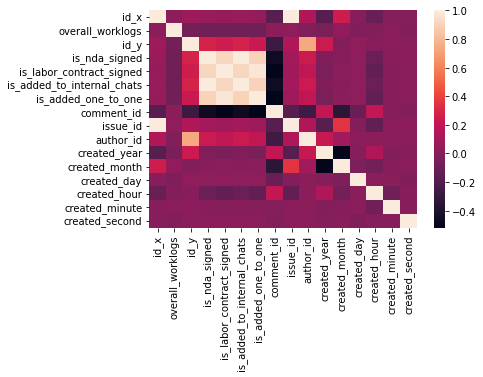

In [ ]:
import seaborn as sns
sns.heatmap(df.corr())

#### id_y 

In [ ]:
df['id_y'].value_counts()

1      1616
365    1024
10      748
86      676
33      579
11      455
97      390
68      350
208     289
242     278
192     267
82      222
330     166
191     160
4       153
197     123
99      107
291     104
13       98
210      83
384      80
193      70
22       67
94       67
195      62
53       56
147      37
306      37
93       33
112      27
107      22
149      22
246      21
37       19
54       17
207      16
58       16
285      11
284       9
8         9
57        8
206       7
20        6
18        6
264       5
98        4
2         4
166       3
204       2
116       1
Name: id_y, dtype: int64

In [ ]:
df['id_y'] = df['id_y'].astype(str)

In [ ]:
df_test['id_y'] = df_test['id_y'].astype(str)

#### position

In [ ]:
df['position'].value_counts()

Web-разработчик                             5905
Разработчик мобильных приложений             274
Системный администратор (DevOps инженер)     222
Менеджер проектов                            122
Директор по IT                                83
Web дизайнер                                  52
DevOps инженер                                27
Инженер тестировщик (QA engineer)              7
Delivery Manager                               2
Директор по стратегическому развитию           1
Name: position, dtype: int64

Разберёмся с пропусками

In [ ]:
df[df['position'].isna()]

,id_x,summary,project_id,assignee_id,creator_id,overall_worklogs,id_y,position,hiring_type,payment_type,...,issue_id,author_id,created_year,created_month,created_day,created_hour,created_minute,created_second,key_first,key_second
142,819919,Сделать мьютекс для изменния баланса водителя,5,1,1,5400,1,NaN,NaN,NaN,...,819919.0,1.0,2019,10,1,15,41,8,SM,10692
143,819910,Проверка баланса клиента при смене номера теле...,5,1,1,9000,1,NaN,NaN,NaN,...,NaN,NaN,2019,10,2,13,21,24,SM,10695
144,819906,FieldDescriptor.java line 295,5,1,1,10800,1,NaN,NaN,NaN,...,819906.0,1.0,2019,10,3,9,35,20,SM,10697
145,819883,DataStorage.java line 220,5,1,1,1200,1,NaN,NaN,NaN,...,819883.0,8.0,2019,10,3,12,1,14,SM,10707
146,819882,Table.java line 682,5,1,1,1800,1,NaN,NaN,NaN,...,NaN,NaN,2019,10,3,12,14,42,SM,10708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9077,721976,We need back to role select buttons at Sign Up...,13,149,147,1200,149,NaN,NaN,NaN,...,NaN,NaN,2020,11,10,12,36,50,BALT,8978
9078,721972,Hero image - Student and Digital Passport,13,149,149,15180,149,NaN,NaN,NaN,...,NaN,NaN,2020,11,10,16,17,54,BALT,8982
9486,682206,Расписать документ по технологической сборке и...,29,166,166,18000,166,NaN,non_staff,NaN,...,NaN,NaN,2020,9,17,9,37,30,FPY,889
9489,682172,Монтаж деталей на модуле камеры,29,166,166,28800,166,NaN,non_staff,NaN,...,682172.0,193.0,2020,10,13,17,12,51,FPY,897


In [ ]:
df_test['position'].value_counts()

Web-разработчик                             707
Системный администратор (DevOps инженер)     35
DevOps инженер                               25
Web дизайнер                                 22
Менеджер проектов                            12
Разработчик мобильных приложений              5
Name: position, dtype: int64

In [ ]:
df_test[df_test['position'].isna()]

,id_x,summary,project_id,assignee_id,creator_id,id_y,position,hiring_type,payment_type,english_level,...,issue_id,author_id,created_year,created_month,created_day,created_hour,created_minute,created_second,key_first,key_second
28,675955,Основные проблемы по корп. отделу (по состояни...,5,1,54,1,NaN,NaN,NaN,NaN,...,675955.0,54.0,2020,1,17,5,19,39,SM,11150
29,675921,Заполнить форму для Билайн. Обновление платфор...,5,1,1,1,NaN,NaN,NaN,NaN,...,675921.0,54.0,2020,1,31,4,22,30,SM,11172
30,675919,На исходящих клиентов не слышно у всех операторов,5,1,1,1,NaN,NaN,NaN,NaN,...,675919.0,112.0,2020,1,31,4,48,32,SM,11173
31,675861,Мигрировать задачи по проекту NambaTaxi из pm....,5,1,54,1,NaN,NaN,NaN,NaN,...,675861.0,54.0,2020,4,19,7,2,4,SM,11185
32,721720,Need to correct indents and size of whiteboard...,13,1,86,1,NaN,NaN,NaN,NaN,...,NaN,NaN,2020,12,1,5,53,53,BALT,9234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676,720825,"""Upgrade to Pro"" - Button on teacher dashboard",13,149,149,149,NaN,NaN,NaN,NaN,...,720825.0,149.0,2021,1,25,12,30,34,BALT,10129
677,856265,Whiteboard - Waiting Room,13,149,149,149,NaN,NaN,NaN,NaN,...,856265.0,149.0,2021,1,26,13,3,36,BALT,10159
678,856257,New Teacher dashboard Layouts,13,149,149,149,NaN,NaN,NaN,NaN,...,NaN,NaN,2021,1,27,6,25,0,BALT,10167
948,721235,"GA: Are we tracking clicks to ""use this lesson...",13,374,1,374,NaN,NaN,NaN,NaN,...,721235.0,374.0,2021,1,5,16,34,23,BALT,9719


In [ ]:
df['position'] = df['position'].fillna('другое')

In [ ]:
df_test['position'] = df_test['position'].fillna('другое')

#### hiring_type

In [ ]:
df['hiring_type'].value_counts()

staff        6393
non_staff     545
Name: hiring_type, dtype: int64

In [ ]:
df['hiring_type'] = df['hiring_type'].fillna('other')

In [ ]:
df_test['hiring_type'].value_counts()

staff        767
non_staff    145
Name: hiring_type, dtype: int64

In [ ]:
df_test['hiring_type'] = df_test['hiring_type'].fillna('other')

#### payment_type

In [ ]:
df['payment_type'].value_counts()

fixed     5228
hourly    1633
Name: payment_type, dtype: int64

In [ ]:
df['payment_type'] = df['payment_type'].fillna('other')

In [ ]:
df_test['payment_type'].value_counts()

fixed     698
hourly    201
Name: payment_type, dtype: int64

In [ ]:
df_test['payment_type'] = df_test['payment_type'].fillna('other')

#### english_level

In [ ]:
df['english_level'].value_counts()

B1    337
C1    161
Name: english_level, dtype: int64

In [ ]:
df_test['english_level'].value_counts()

B1    26
C1    11
Name: english_level, dtype: int64

In [ ]:
df = df.drop('english_level', axis=1)

In [ ]:
df_test = df_test.drop('english_level', axis=1)

#### is_nda_signed

In [ ]:
df['is_nda_signed'].value_counts()

1    6114
0    2518
Name: is_nda_signed, dtype: int64

In [ ]:
df_test['is_nda_signed'].value_counts()

1    626
0    444
Name: is_nda_signed, dtype: int64

#### is_labor_contract_signed

In [ ]:
df['is_labor_contract_signed'].value_counts()

1    5812
0    2820
Name: is_labor_contract_signed, dtype: int64

In [ ]:
df_test['is_labor_contract_signed'].value_counts()

1    587
0    483
Name: is_labor_contract_signed, dtype: int64

#### is_added_to_internal_chats

In [ ]:
df['is_added_to_internal_chats'].value_counts()

1    6114
0    2518
Name: is_added_to_internal_chats, dtype: int64

In [ ]:
df_test['is_added_to_internal_chats'].value_counts()

1    626
0    444
Name: is_added_to_internal_chats, dtype: int64

#### is_added_one_to_one

In [ ]:
df['is_added_one_to_one'].value_counts()

1    5728
0    2904
Name: is_added_one_to_one, dtype: int64

In [ ]:
df_test['is_added_one_to_one'].value_counts()

1    587
0    483
Name: is_added_one_to_one, dtype: int64

#### comment_id

In [ ]:
df['comment_id'].value_counts()

65956.0    1
13817.0    1
14138.0    1
14185.0    1
14282.0    1
          ..
68816.0    1
68807.0    1
68653.0    1
68697.0    1
76101.0    1
Name: comment_id, Length: 3454, dtype: int64

In [ ]:
df['comment_id'] = df['comment_id'].fillna(0)

In [ ]:
df_test['comment_id'] = df_test['comment_id'].fillna(0)

#### issue_id

In [ ]:
df['issue_id'].value_counts()

819949.0    1
727291.0    1
726637.0    1
726534.0    1
726405.0    1
           ..
819251.0    1
819250.0    1
819169.0    1
676067.0    1
670930.0    1
Name: issue_id, Length: 3454, dtype: int64

In [ ]:
df_test['issue_id'].value_counts()

675975.0    1
721278.0    1
721845.0    1
721875.0    1
856265.0    1
           ..
721478.0    1
721517.0    1
721521.0    1
721523.0    1
670929.0    1
Name: issue_id, Length: 479, dtype: int64

In [ ]:
df['issue_id'] = df['issue_id'].fillna(0)

In [ ]:
df_test['issue_id'] = df_test['issue_id'].fillna(0)

#### author_id

In [ ]:
df['author_id'].value_counts()

1.0      769
10.0     456
193.0    377
58.0     217
365.0    165
192.0    132
33.0     117
37.0     108
68.0      94
11.0      78
330.0     77
208.0     66
4.0       62
147.0     60
86.0      59
94.0      54
82.0      53
191.0     53
195.0     41
384.0     40
97.0      40
242.0     38
54.0      33
197.0     28
13.0      28
22.0      25
291.0     21
99.0      21
112.0     18
93.0      16
246.0     14
374.0     14
207.0     13
8.0       12
149.0     10
206.0      6
116.0      6
210.0      5
326.0      5
53.0       5
284.0      5
264.0      3
285.0      3
18.0       2
2.0        2
107.0      2
85.0       1
Name: author_id, dtype: int64

In [ ]:
df['author_id'] = df['author_id'].fillna(0)

In [ ]:
df_test['author_id'] = df_test['author_id'].fillna(0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8632 entries, 0 to 9588
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_x                        8632 non-null   int64  
 1   summary                     8632 non-null   object 
 2   project_id                  8632 non-null   object 
 3   assignee_id                 8632 non-null   object 
 4   creator_id                  8632 non-null   object 
 5   overall_worklogs            8632 non-null   int64  
 6   id_y                        8632 non-null   object 
 7   position                    8632 non-null   object 
 8   hiring_type                 8632 non-null   object 
 9   payment_type                8632 non-null   object 
 10  is_nda_signed               8632 non-null   int64  
 11  is_labor_contract_signed    8632 non-null   int64  
 12  is_added_to_internal_chats  8632 non-null   int64  
 13  is_added_one_to_one         8632 

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1070 entries, 0 to 1069
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_x                        1070 non-null   int64  
 1   summary                     1070 non-null   object 
 2   project_id                  1070 non-null   object 
 3   assignee_id                 1070 non-null   object 
 4   creator_id                  1070 non-null   object 
 5   id_y                        1070 non-null   object 
 6   position                    1070 non-null   object 
 7   hiring_type                 1070 non-null   object 
 8   payment_type                1070 non-null   object 
 9   is_nda_signed               1070 non-null   int64  
 10  is_labor_contract_signed    1070 non-null   int64  
 11  is_added_to_internal_chats  1070 non-null   int64  
 12  is_added_one_to_one         1070 non-null   int64  
 13  comment_id                  1070 

#### summary

In [ ]:
df['summary'].value_counts().head(60)

Test layout                                                                  34
Planing task                                                                 29
Planing tasks                                                                24
Work on feedback                                                             16
Fix bugs                                                                     10
Planing tasks                                                                10
Planning                                                                      8
Test in different browsers                                                    8
Planning                                                                      7
Code refactoring                                                              7
Need to close slate in the process of deploy                                  6
Task planning                                                                 6
Dump from production                    

In [ ]:
import string
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('russian'))
stop_words_eng = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# длина описания
df['num_of_sent'] = df['summary'].apply(lambda x: len(re.findall('\n',str(x)))+1)
df_test['num_of_sent'] = df_test['summary'].apply(lambda x: len(re.findall('\n',str(x)))+1)
# количество слов
df['num_of_word'] = df['summary'].apply(lambda x: len(str(x).split()))
df_test['num_of_word'] = df_test['summary'].apply(lambda x: len(str(x).split()))
# количество уникальных слов
df['num_of_unique_word'] = df['summary'].apply(lambda x: len(set(str(x).split())))
df_test['num_of_unique_word'] = df_test['summary'].apply(lambda x: len(set(str(x).split())))
# количество символов
df['num_of_letters'] = df['summary'].apply(lambda x: len(str(x)))
df_test['num_of_letters'] = df_test['summary'].apply(lambda x: len(str(x)))
# количество знаков препинания
df["num_of_punct"] = df['summary'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_test["num_of_punct"] = df_test['summary'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
# количество слов капсом
df["num_of_words_upper"] = df['summary'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
df_test["num_of_words_upper"] = df_test['summary'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
# количество слов с заглавной буквы
df["num_of_words_title"] = df['summary'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
df_test["num_of_words_title"] = df_test['summary'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
# количество стоп-слов
df["num_of_stopwords"] = df['summary'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words or w in stop_words_eng]))
df_test["num_of_stopwords"] = df_test['summary'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words or w in stop_words_eng]))
# средняя длина слова в тексте
df["mean_word_len"] = df['summary'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_test["mean_word_len"] = df_test['summary'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
# процент уникальных слов
df['word_unique_percent'] = df['num_of_unique_word']*100/df['num_of_word']
df_test['word_unique_percent'] = df_test['num_of_unique_word']*100/df_test['num_of_word']
# процент знаков пунктуации
df['punct_percent'] = df['num_of_punct']*100/df['num_of_word']
df_test['punct_percent'] = df_test['num_of_punct']*100/df_test['num_of_word']

In [ ]:
patterns = "[!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
stopwords_en = stopwords.words("english")
stop = stopwords_en+stopwords_ru

morph = pymorphy2.MorphAnalyzer()
def lemmatize(doc):
    doc = doc.lower()
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stop:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            tokens.append(token)
            j = ' '.join(tokens)
    
    return j

In [ ]:
morph_eng = WordNetLemmatizer()

def lemmatize_eng(doc):
    doc = doc.lower()
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stop:
            token = token.strip()
            token = morph_eng.lemmatize(token)
            tokens.append(token)
            j = ' '.join(tokens)
    
    return j


In [ ]:
df['summary_lemm'] = df['summary'].apply(lemmatize)

In [ ]:
df['summary_lemm'] = df['summary'].apply(lemmatize_eng)

In [ ]:
df

,id_x,summary,project_id,assignee_id,creator_id,overall_worklogs,id_y,position,hiring_type,payment_type,...,num_of_unique_word,num_of_letters,num_of_punct,num_of_words_upper,num_of_words_title,num_of_stopwords,mean_word_len,word_unique_percent,punct_percent,summary_lemm
0,819952,"UI тесты по заказу ""Добро КейДжи""",5,93,93,1800,93,Разработчик мобильных приложений,staff,fixed,...,6,33,2,1,1,1,4.666667,100.0,33.333333,ui тесты заказу добро кейджи
1,819949,"UI тесты раздела ""Профиль""",5,93,93,7200,93,Разработчик мобильных приложений,staff,fixed,...,4,26,2,1,1,0,5.750000,100.0,50.000000,ui тесты раздела профиль
2,819947,"UI тесты раздела ""Личный счет""",5,93,93,14400,93,Разработчик мобильных приложений,staff,fixed,...,5,30,2,1,1,0,5.200000,100.0,40.000000,ui тесты раздела личный счет
3,819943,"UI тесты раздела ""Новости""",5,93,93,900,93,Разработчик мобильных приложений,staff,fixed,...,4,26,2,1,1,0,5.750000,100.0,50.000000,ui тесты раздела новости
4,819941,"UI тесты раздела ""Зоны скидок и доплат""",5,93,93,900,93,Разработчик мобильных приложений,staff,fixed,...,7,39,2,1,1,1,4.714286,100.0,28.571429,ui тесты раздела зоны скидок доплат
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9584,688397,Layout - Service and postcode search results p...,33,98,58,18000,98,Web-разработчик,staff,fixed,...,8,50,1,0,2,1,5.250000,100.0,12.500000,layout service postcode search result page
9585,670934,Set up the neo4j by using a dataset from Slack,56,2,2,16200,2,Web-разработчик,staff,fixed,...,10,46,0,0,2,5,3.700000,100.0,0.000000,set neo4j using dataset slack
9586,670932,Set up a graph in neo4j by GitLab dataset,56,2,2,3600,2,Web-разработчик,staff,fixed,...,9,41,0,0,1,4,3.666667,100.0,0.000000,set graph neo4j gitlab dataset
9587,670931,Parse a dataset from teacherly slack,56,2,2,6300,2,Web-разработчик,staff,fixed,...,6,36,0,0,1,2,5.166667,100.0,0.000000,parse dataset teacherly slack


Посмотрим на самые частые значения

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



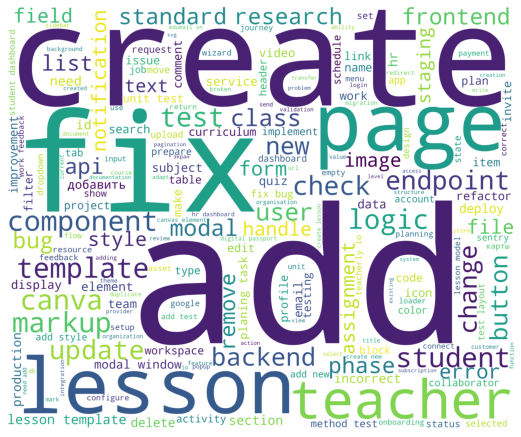

In [ ]:
# Получение текстовой строки из списка слов
def str_corpus(corpus):
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus
# Получение списка всех слов в корпусе
def get_corpus(data):
    corpus = []
    for phrase in data:
        for word in phrase.split():
            corpus.append(word)
    return corpus
# Получение облака слов
def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                              #stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(str_corpus(corpus))
    return wordCloud

corpus = get_corpus(df['summary_lemm'].values)
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

In [ ]:
df['summary_lemm'].value_counts().head(60)

planing task                                                        68
test layout                                                         40
work feedback                                                       21
planning                                                            15
fix bug                                                             12
task planning                                                       11
need close slate process deploy                                      8
test different browser                                               8
code refactoring                                                     7
study bug                                                            7
need prepare production db backup                                    6
dump production                                                      5
test staging                                                         5
smoke test staging                                                   5
test c

In [ ]:
df_test['summary'].value_counts().head(60)

Investigate the task                                                                                                         5
Unit tests                                                                                                                   2
UserController.php                                                                                                           2
Develop the markup of the page                                                                                               2
Refactor class components to functional                                                                                      2
Коммуникации Гаухар                                                                                                          2
Deploy EVN and ETL                                                                                                           2
Add unit tests                                                                                                 

In [ ]:
patterns = "[!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
stopwords_en = stopwords.words("english")
stop = stopwords_en+stopwords_ru

morph = pymorphy2.MorphAnalyzer()
def lemmatize(doc):
    doc = doc.lower()
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stop:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            tokens.append(token)
            j = ' '.join(tokens)
    
    return j

In [ ]:
morph_eng = WordNetLemmatizer()

def lemmatize_eng(doc):
    doc = doc.lower()
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stop:
            token = token.strip()
            token = morph_eng.lemmatize(token)
            tokens.append(token)
            j = ' '.join(tokens)
    
    return j


In [ ]:
df_test['summary_lemm'] = df_test['summary'].apply(lemmatize)

In [ ]:
df_test['summary_lemm'] = df_test['summary'].apply(lemmatize_eng)

In [ ]:
df_test

,id_x,summary,project_id,assignee_id,creator_id,id_y,position,hiring_type,payment_type,is_nda_signed,...,num_of_unique_word,num_of_letters,num_of_punct,num_of_words_upper,num_of_words_title,num_of_stopwords,mean_word_len,word_unique_percent,punct_percent,summary_lemm
0,675975,Выгрузить все mp3 файлы звонков на диск,5,112,112,112,DevOps инженер,staff,fixed,0,...,7,39,0,0,1,2,4.714286,100.0,0.0,выгрузить mp3 файлы звонков диск
1,675972,Удалить файлы mp3 звонков с сервера до 01.01.2019,5,112,112,112,DevOps инженер,staff,fixed,0,...,8,49,2,0,1,2,5.250000,100.0,25.0,удалить файлы mp3 звонков сервера 01 01 2019
2,675917,Водители не могут нажать на кнопку «на месте» ...,5,112,1,112,DevOps инженер,staff,fixed,0,...,11,63,0,0,1,3,4.818182,100.0,0.0,водители могут нажать кнопку «на месте» заверш...
3,675915,Категория тарифа в карточке тарифа не всегда а...,5,112,1,112,DevOps инженер,staff,fixed,0,...,7,60,0,0,1,3,6.625000,87.5,0.0,категория тарифа карточке тарифа автозаполняется
4,675912,Добавить ip адрес с список разрешённых к подкл...,5,112,1,112,DevOps инженер,staff,fixed,0,...,9,69,2,0,1,3,6.000000,90.0,20.0,добавить ip адрес список разрешённых подключен...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,2176348,Проверить почему скрипт деактивирует активную ...,29,191,191,191,Web-разработчик,staff,hourly,1,...,6,52,0,0,1,0,7.833333,100.0,0.0,проверить почему скрипт деактивирует активную ...
1066,2176673,[OME] Ограничить доступ к сервису,29,191,192,191,Web-разработчик,staff,hourly,1,...,5,33,2,1,1,1,5.800000,100.0,40.0,ome ограничить доступ сервису
1067,686533,Create design for email template,33,246,58,246,Web дизайнер,staff,hourly,1,...,5,32,0,0,1,1,5.600000,100.0,0.0,create design email template
1068,686395,Help with transforming PWA into Google Play,33,13,58,13,Разработчик мобильных приложений,staff,fixed,1,...,7,43,0,1,3,2,5.285714,100.0,0.0,help transforming pwa google play


Посмотрим на самые частые значения

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



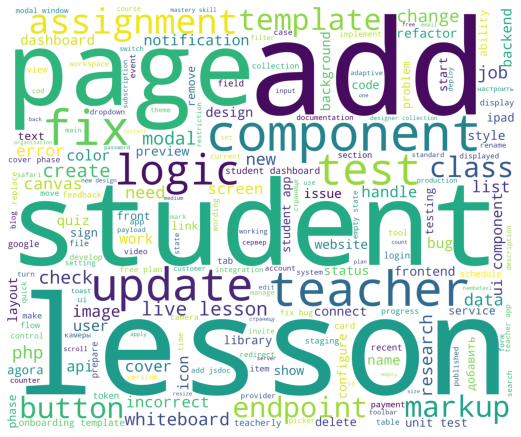

In [ ]:
# Получение текстовой строки из списка слов
def str_corpus(corpus):
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus
# Получение списка всех слов в корпусе
def get_corpus(data):
    corpus = []
    for phrase in data:
        for word in phrase.split():
            corpus.append(word)
    return corpus
# Получение облака слов
def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                              #stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(str_corpus(corpus))
    return wordCloud

corpus = get_corpus(df_test['summary_lemm'].values)
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

In [ ]:
df_test['summary_lemm'].value_counts().head(60)

investigate task                                                                              5
usercontroller php                                                                            2
fix bug testing                                                                               2
develop markup page                                                                           2
коммуникации гаухар                                                                           2
refactor class component functional                                                           2
deploy evn etl                                                                                2
unit test                                                                                     2
add jsdoc description                                                                         2
add unit test                                                                                 2
work feedback get rid class component us

In [ ]:
df = df.drop('summary', axis=1)

In [ ]:
df_test = df_test.drop('summary', axis=1)

In [ ]:
df['summary_len']=df['summary_lemm'].apply(lambda x:len(x.split()))
df_test['summary_len']=df_test['summary_lemm'].apply(lambda x:len(x.split()))

In [ ]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(df['summary_lemm'])
X_test = vectorizer.transform(df_test['summary_lemm'])

In [ ]:
%%time
trans = Normalizer()
X_train_len=trans.fit_transform(df['summary_len'].values.reshape(-1,1))
X_test_len=trans.transform(df_test['summary_len'].values.reshape(-1,1))

CPU times: user 1.5 ms, sys: 0 ns, total: 1.5 ms
Wall time: 1.56 ms


In [ ]:
%%time
train_s=hstack((X_train,X_train_len))
test_s=hstack((X_test,X_test_len))

CPU times: user 1.8 ms, sys: 0 ns, total: 1.8 ms
Wall time: 1.81 ms


In [ ]:
y = df[['overall_worklogs']]

In [ ]:
print(train_s.shape,y.shape)
print(test_s.shape)

(8632, 5746) (8632, 1)
(1070, 5746)


In [ ]:
params_lgb = {
    "n_estimators": 1000,
    "verbose": -1
}

In [ ]:
model = LGBMRegressor(**params_lgb)
model.fit(train_s, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



LGBMRegressor(n_estimators=1000, verbose=-1)

In [ ]:
model2 = CatBoostRegressor(depth=10, random_state=42)
model2.fit(train_s, y)

Learning rate set to 0.057555
0:	learn: 7123.8793082	total: 319ms	remaining: 5m 18s
1:	learn: 7116.3623013	total: 634ms	remaining: 5m 16s
2:	learn: 7111.2008571	total: 945ms	remaining: 5m 13s
3:	learn: 7105.4399356	total: 1.26s	remaining: 5m 14s
4:	learn: 7099.5442095	total: 1.58s	remaining: 5m 14s
5:	learn: 7093.6633747	total: 1.89s	remaining: 5m 13s
6:	learn: 7087.0721502	total: 2.21s	remaining: 5m 13s
7:	learn: 7082.6647392	total: 2.52s	remaining: 5m 13s
8:	learn: 7076.7830652	total: 2.84s	remaining: 5m 12s
9:	learn: 7071.8595685	total: 3.16s	remaining: 5m 12s
10:	learn: 7066.9415399	total: 3.46s	remaining: 5m 11s
11:	learn: 7062.5878758	total: 3.78s	remaining: 5m 11s
12:	learn: 7058.3915686	total: 4.1s	remaining: 5m 11s
13:	learn: 7055.1230561	total: 4.42s	remaining: 5m 11s
14:	learn: 7050.9573337	total: 4.73s	remaining: 5m 10s
15:	learn: 7047.6446874	total: 5.06s	remaining: 5m 10s
16:	learn: 7045.3451958	total: 5.36s	remaining: 5m 9s
17:	learn: 7040.8837499	total: 5.67s	remaining:

In [ ]:
model3 = Ridge(copy_X=False)
model3.fit(train_s, y)

Ridge(copy_X=False)

In [ ]:
model4 = xgb.XGBRegressor(n_estimators=500, random_state=42)
model4.fit(train_s, y)

[16:02:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=500, random_state=42)

In [ ]:
first_pred_1 = model.predict(train_s)
first_pred_2 = model2.predict(train_s)
first_pred_3 = model3.predict(train_s)
first_pred_4 = model4.predict(train_s)

stack_pred = np.column_stack((first_pred_1,first_pred_2,first_pred_3,first_pred_4))

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning:

Converting data to scipy sparse matrix.



In [ ]:
df['first_pred_1'] = first_pred_1

In [ ]:
df['first_pred_2'] = first_pred_2

In [ ]:
df['first_pred_3'] = first_pred_3

In [ ]:
df['first_pred_4'] = first_pred_4

In [ ]:
test_pred_1 = model.predict(test_s)
test_pred_2 = model2.predict(test_s)
test_pred_3 = model3.predict(test_s)
test_pred_4 = model4.predict(test_s)

In [ ]:
df_test['first_pred_1'] = test_pred_1

In [ ]:
df_test['first_pred_2'] = test_pred_2

In [ ]:
df_test['first_pred_3'] = test_pred_3

In [ ]:
df_test['first_pred_4'] = test_pred_4

#### text

In [ ]:
df['text'].value_counts()

Fixed                                                                                                                                                                                           21
LGTM                                                                                                                                                                                            18
\n\n!image.png|thumbnail!                                                                                                                                                                       14
 !screenshot-1.png|thumbnail!                                                                                                                                                                    8
проверила, все ок                                                                                                                                                                                5
                         

In [ ]:
df['text'] = df['text'].fillna('0')

In [ ]:
df_test['text'].value_counts()

LGTM                                                                                                                                                                                                                                                                                                                                          9
Fixed                                                                                                                                                                                                                                                                                                                                         8
Issue fixed.                                                                                                                                                                                                                                                                                                                            

In [ ]:
patterns = "[!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
stopwords_en = stopwords.words("english")
stop = stopwords_en+stopwords_ru

morph = pymorphy2.MorphAnalyzer()
def lemmatize(doc):
    doc = doc.lower()
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stop:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            tokens.append(token)
            j = ' '.join(tokens)
    
    return j

In [ ]:
morph_eng = WordNetLemmatizer()

def lemmatize_eng(doc):
    doc = doc.lower()
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stop:
            token = token.strip()
            token = morph_eng.lemmatize(token)
            tokens.append(token)
            j = ' '.join(tokens)
    
    return j


In [ ]:
df['text_lemm'] = df['text'].apply(lemmatize)

In [ ]:
df['text_lemm'] = df['text'].apply(lemmatize_eng)

In [ ]:
df

,id_x,project_id,assignee_id,creator_id,overall_worklogs,id_y,position,hiring_type,payment_type,is_nda_signed,...,mean_word_len,word_unique_percent,punct_percent,summary_lemm,summary_len,first_pred_1,first_pred_2,first_pred_3,first_pred_4,text_lemm
0,819952,5,93,93,1800,93,Разработчик мобильных приложений,staff,fixed,1,...,4.666667,100.0,33.333333,ui тесты заказу добро кейджи,5,5967.844574,7884.725290,6098.225104,7934.740234,0
1,819949,5,93,93,7200,93,Разработчик мобильных приложений,staff,fixed,1,...,5.750000,100.0,50.000000,ui тесты раздела профиль,4,6767.889017,8021.370095,5924.238081,8158.895996,приверила приняла mr
2,819947,5,93,93,14400,93,Разработчик мобильных приложений,staff,fixed,1,...,5.200000,100.0,40.000000,ui тесты раздела личный счет,5,7438.029989,7751.933703,9008.460293,7934.740234,0
3,819943,5,93,93,900,93,Разработчик мобильных приложений,staff,fixed,1,...,5.750000,100.0,50.000000,ui тесты раздела новости,4,6767.889017,7895.750800,5296.827689,8158.895996,0
4,819941,5,93,93,900,93,Разработчик мобильных приложений,staff,fixed,1,...,4.714286,100.0,28.571429,ui тесты раздела зоны скидок доплат,6,4775.531056,7685.025573,4789.032787,7934.740234,приняла mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9584,688397,33,98,58,18000,98,Web-разработчик,staff,fixed,1,...,5.250000,100.0,12.500000,layout service postcode search result page,6,12225.970499,11667.474265,11458.769825,9868.943359,alisa http gitlab com ally 8253 mentioned issu...
9585,670934,56,2,2,16200,2,Web-разработчик,staff,fixed,0,...,3.700000,100.0,0.000000,set neo4j using dataset slack,5,10066.172711,8070.301063,8733.463267,7934.740234,read neo4j documentation also able get user us...
9586,670932,56,2,2,3600,2,Web-разработчик,staff,fixed,0,...,3.666667,100.0,0.000000,set graph neo4j gitlab dataset,5,5890.662984,7067.385106,5991.987714,7023.960449,0
9587,670931,56,2,2,6300,2,Web-разработчик,staff,fixed,0,...,5.166667,100.0,0.000000,parse dataset teacherly slack,4,6910.669297,7628.138596,8331.204169,7736.216797,0


In [ ]:
df_test['text'] = df_test['text'].fillna('0')

In [ ]:
df_test['text_lemm'] = df_test['text'].apply(lemmatize)

In [ ]:
df_test['text_lemm'] = df_test['text'].apply(lemmatize_eng)

In [ ]:
df = df.drop('text', axis=1)

In [ ]:
df_test = df_test.drop('text', axis=1)

In [ ]:
df['text_len']=df['text_lemm'].apply(lambda x:len(x.split()))
df_test['text_len']=df_test['text_lemm'].apply(lambda x:len(x.split()))

In [ ]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(df['text_lemm'])
X_test = vectorizer.transform(df_test['text_lemm'])

In [ ]:
%%time
trans = Normalizer()
X_train_len=trans.fit_transform(df['text_len'].values.reshape(-1,1))
X_test_len=trans.transform(df_test['text_len'].values.reshape(-1,1))

CPU times: user 102 µs, sys: 968 µs, total: 1.07 ms
Wall time: 1.08 ms


In [ ]:
%%time
train_s=hstack((X_train,X_train_len))
test_s=hstack((X_test,X_test_len))

CPU times: user 4.38 ms, sys: 0 ns, total: 4.38 ms
Wall time: 5.59 ms


In [ ]:
y = df[['overall_worklogs']]

In [ ]:
print(train_s.shape,y.shape)
print(test_s.shape)

(8632, 14886) (8632, 1)
(1070, 14886)


In [ ]:
params_lgb = {
    "n_estimators": 1000,
    "verbose": -1
}

In [ ]:
model = LGBMRegressor(**params_lgb)
model.fit(train_s, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



LGBMRegressor(n_estimators=1000, verbose=-1)

In [ ]:
model2 = CatBoostRegressor(depth=10, random_state=42)
model2.fit(train_s, y)

Learning rate set to 0.057555
0:	learn: 7127.6011123	total: 603ms	remaining: 10m 2s
1:	learn: 7122.8282901	total: 1.22s	remaining: 10m 6s
2:	learn: 7117.9970664	total: 1.81s	remaining: 10m 1s
3:	learn: 7113.2800380	total: 2.39s	remaining: 9m 55s
4:	learn: 7109.0873918	total: 2.98s	remaining: 9m 53s
5:	learn: 7105.1385445	total: 3.57s	remaining: 9m 51s
6:	learn: 7101.3904643	total: 4.16s	remaining: 9m 50s
7:	learn: 7097.8863797	total: 4.75s	remaining: 9m 49s
8:	learn: 7092.5672733	total: 5.36s	remaining: 9m 50s
9:	learn: 7089.1443294	total: 5.95s	remaining: 9m 49s
10:	learn: 7085.5851775	total: 6.55s	remaining: 9m 48s
11:	learn: 7083.9296803	total: 7.13s	remaining: 9m 47s
12:	learn: 7079.1442103	total: 7.72s	remaining: 9m 46s
13:	learn: 7075.3292511	total: 8.31s	remaining: 9m 45s
14:	learn: 7070.8826320	total: 8.89s	remaining: 9m 43s
15:	learn: 7068.3463310	total: 9.48s	remaining: 9m 43s
16:	learn: 7064.2260058	total: 10.1s	remaining: 9m 42s
17:	learn: 7061.7253078	total: 10.7s	remainin

In [ ]:
model3 = Ridge(copy_X=False)
model3.fit(train_s, y)

Ridge(copy_X=False)

In [ ]:
model4 = xgb.XGBRegressor(n_estimators=500, random_state=42)
model4.fit(train_s, y)

[16:13:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=500, random_state=42)

In [ ]:
first_pred_1 = model.predict(train_s)
first_pred_2 = model2.predict(train_s)
first_pred_3 = model3.predict(train_s)
first_pred_4 = model4.predict(train_s)

stack_pred = np.column_stack((first_pred_1,first_pred_2,first_pred_3,first_pred_4))

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:478: UserWarning:

Converting data to scipy sparse matrix.



In [ ]:
df['text_first_pred_1'] = first_pred_1

In [ ]:
df['text_first_pred_2'] = first_pred_2

In [ ]:
df['text_first_pred_3'] = first_pred_3

In [ ]:
df['text_first_pred_4'] = first_pred_4

In [ ]:
test_pred_1 = model.predict(test_s)
test_pred_2 = model2.predict(test_s)
test_pred_3 = model3.predict(test_s)
test_pred_4 = model4.predict(test_s)

In [ ]:
df_test['text_first_pred_1'] = test_pred_1

In [ ]:
df_test['text_first_pred_2'] = test_pred_2

In [ ]:
df_test['text_first_pred_3'] = test_pred_3

In [ ]:
df_test['text_first_pred_4'] = test_pred_4

### ML

In [ ]:
df

,id_x,project_id,assignee_id,creator_id,overall_worklogs,id_y,position,hiring_type,payment_type,is_nda_signed,...,first_pred_1,first_pred_2,first_pred_3,first_pred_4,text_lemm,text_len,text_first_pred_1,text_first_pred_2,text_first_pred_3,text_first_pred_4
0,819952,5,93,93,1800,93,Разработчик мобильных приложений,staff,fixed,1,...,5967.844574,7884.725290,6098.225104,7934.740234,0,1,7754.480982,7608.388180,7742.750827,7696.351562
1,819949,5,93,93,7200,93,Разработчик мобильных приложений,staff,fixed,1,...,6767.889017,8021.370095,5924.238081,8158.895996,приверила приняла mr,3,5825.982495,6957.011013,6049.196604,8925.247070
2,819947,5,93,93,14400,93,Разработчик мобильных приложений,staff,fixed,1,...,7438.029989,7751.933703,9008.460293,7934.740234,0,1,7754.480982,7608.388180,7742.750827,7696.351562
3,819943,5,93,93,900,93,Разработчик мобильных приложений,staff,fixed,1,...,6767.889017,7895.750800,5296.827689,8158.895996,0,1,7754.480982,7608.388180,7742.750827,7696.351562
4,819941,5,93,93,900,93,Разработчик мобильных приложений,staff,fixed,1,...,4775.531056,7685.025573,4789.032787,7934.740234,приняла mr,2,5825.982495,6257.222498,4674.305573,8068.469238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9584,688397,33,98,58,18000,98,Web-разработчик,staff,fixed,1,...,12225.970499,11667.474265,11458.769825,9868.943359,alisa http gitlab com ally 8253 mentioned issu...,29,16763.139174,10513.480786,13650.710240,12478.853516
9585,670934,56,2,2,16200,2,Web-разработчик,staff,fixed,0,...,10066.172711,8070.301063,8733.463267,7934.740234,read neo4j documentation also able get user us...,10,15883.308337,9962.379959,12435.592941,8316.957031
9586,670932,56,2,2,3600,2,Web-разработчик,staff,fixed,0,...,5890.662984,7067.385106,5991.987714,7023.960449,0,1,7754.480982,7608.388180,7742.750827,7696.351562
9587,670931,56,2,2,6300,2,Web-разработчик,staff,fixed,0,...,6910.669297,7628.138596,8331.204169,7736.216797,0,1,7754.480982,7608.388180,7742.750827,7696.351562


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8632 entries, 0 to 9588
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_x                        8632 non-null   int64  
 1   project_id                  8632 non-null   object 
 2   assignee_id                 8632 non-null   object 
 3   creator_id                  8632 non-null   object 
 4   overall_worklogs            8632 non-null   int64  
 5   id_y                        8632 non-null   object 
 6   position                    8632 non-null   object 
 7   hiring_type                 8632 non-null   object 
 8   payment_type                8632 non-null   object 
 9   is_nda_signed               8632 non-null   int64  
 10  is_labor_contract_signed    8632 non-null   int64  
 11  is_added_to_internal_chats  8632 non-null   int64  
 12  is_added_one_to_one         8632 non-null   int64  
 13  comment_id                  8632 

In [ ]:
X = df.drop(['overall_worklogs', 'summary_lemm', 'text_lemm', 'payment_type', 'comment_id', 'hiring_type',	'issue_id', 'author_id',	'is_labor_contract_signed',
             'created_year',	'is_nda_signed',	'is_added_to_internal_chats',	'is_added_one_to_one',	'key_second', 	'created_second', 'created_minute',	'created_day',
             'key_first',	'assignee_id',	'id_x',	'created_hour',	'created_month',	'text_first_pred_4',	'id_y'], axis = 1)
y = df["overall_worklogs"]

In [ ]:
X_test = df_test.drop(['summary_lemm', 'text_lemm', 'payment_type', 'comment_id', 'hiring_type',	'issue_id', 'author_id',	'is_labor_contract_signed',
             'created_year',	'is_nda_signed',	'is_added_to_internal_chats',	'is_added_one_to_one',	'key_second', 	'created_second',
             	'created_minute',	'created_day',	'key_first',	'assignee_id',	'id_x',	'created_hour',	'created_month',	'text_first_pred_4',	'id_y'], axis = 1)

In [ ]:
X.shape

(8632, 23)

In [ ]:
cat_features = ['project_id', 'creator_id', 'position']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8632 entries, 0 to 9588
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_x                        8632 non-null   int64  
 1   project_id                  8632 non-null   object 
 2   assignee_id                 8632 non-null   object 
 3   creator_id                  8632 non-null   object 
 4   overall_worklogs            8632 non-null   int64  
 5   id_y                        8632 non-null   object 
 6   position                    8632 non-null   object 
 7   hiring_type                 8632 non-null   object 
 8   payment_type                8632 non-null   object 
 9   is_nda_signed               8632 non-null   int64  
 10  is_labor_contract_signed    8632 non-null   int64  
 11  is_added_to_internal_chats  8632 non-null   int64  
 12  is_added_one_to_one         8632 non-null   int64  
 13  comment_id                  8632 

In [ ]:
df[cat_features] = df[cat_features].astype(str)

In [ ]:
cat_model = CatBoostRegressor(loss_function='MAE', iterations=2001, verbose=10, cat_features=cat_features, depth=10, random_state=42)
cat_model.fit(X, y)

0:	learn: 5229.0928654	total: 33.1ms	remaining: 1m 6s
10:	learn: 4345.7234045	total: 346ms	remaining: 1m 2s
20:	learn: 3753.1028974	total: 661ms	remaining: 1m 2s
30:	learn: 3294.0602011	total: 1s	remaining: 1m 3s
40:	learn: 2990.8928211	total: 1.36s	remaining: 1m 4s
50:	learn: 2769.7290729	total: 1.68s	remaining: 1m 4s
60:	learn: 2616.3045370	total: 1.98s	remaining: 1m 2s
70:	learn: 2497.1118693	total: 2.31s	remaining: 1m 2s
80:	learn: 2404.5431166	total: 2.57s	remaining: 1m 1s
90:	learn: 2334.4853678	total: 2.88s	remaining: 1m
100:	learn: 2279.9967675	total: 3.21s	remaining: 1m
110:	learn: 2243.0098739	total: 3.48s	remaining: 59.3s
120:	learn: 2204.9294171	total: 3.81s	remaining: 59.2s
130:	learn: 2180.4056346	total: 4.07s	remaining: 58.1s
140:	learn: 2150.8921348	total: 4.37s	remaining: 57.7s
150:	learn: 2122.5252699	total: 4.68s	remaining: 57.3s
160:	learn: 2101.3015958	total: 5s	remaining: 57.2s
170:	learn: 2082.6569318	total: 5.31s	remaining: 56.9s
180:	learn: 2065.6772295	total: 

In [ ]:
cat_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,first_pred_1,24.471241
1,first_pred_3,11.397176
2,first_pred_2,10.271486
3,text_first_pred_1,8.543210
4,project_id,6.384767
5,creator_id,5.424752
6,first_pred_4,5.033263
7,text_first_pred_2,4.914081
8,text_first_pred_3,4.839576
9,mean_word_len,3.442710


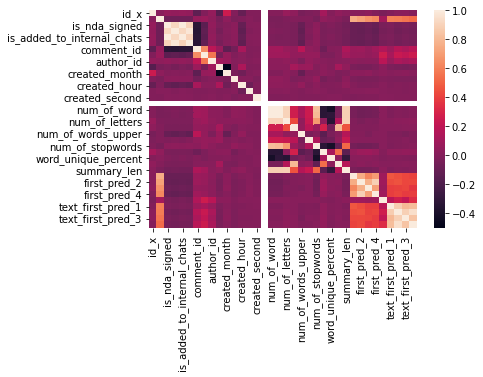

In [ ]:
sns.heatmap(df.corr())

## Оценка точности

In [ ]:
pred = cat_model.predict(X_test)

In [ ]:
df_sub = pd.read_csv('/content/sample_solution.csv')

In [ ]:
df_sub

,id,overall_worklogs
0,675975,0
1,675972,0
2,675965,0
3,675961,0
4,675955,0
...,...,...
1065,702545,0
1066,702528,0
1067,702499,0
1068,702376,0


In [ ]:
df_sub["overall_worklogs"] = pred
df_sub.head(4)

,id,overall_worklogs
0,675975,12090.643049
1,675972,3821.131655
2,675965,4218.650507
3,675961,16294.308730


In [ ]:
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                1070 non-null   int64  
 1   overall_worklogs  1070 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 16.8 KB


In [ ]:
df_sub.to_csv("/content/submission.csv", index = False)

In [ ]:
df_sub

,id,overall_worklogs
0,675975,12090.643049
1,675972,3821.131655
2,675965,4218.650507
3,675961,16294.308730
4,675955,14834.141291
...,...,...
1065,702545,11530.287243
1066,702528,15293.547761
1067,702499,14539.331386
1068,702376,6984.431102


In [ ]:
cat_model.get_feature_importance(prettified=True)


,Feature Id,Importances
0,first_pred_1,24.471241
1,first_pred_3,11.397176
2,first_pred_2,10.271486
3,text_first_pred_1,8.543210
4,project_id,6.384767
5,creator_id,5.424752
6,first_pred_4,5.033263
7,text_first_pred_2,4.914081
8,text_first_pred_3,4.839576
9,mean_word_len,3.442710
